# Setup

Make sure that the working directory is correct.

In [1]:
import os

print(os.getcwd())
os.chdir('/home/ferdi/nonlinear_irm/code')
print(f"Current working dir: {os.getcwd()}")

if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

/home/ferdi/nonlinear_irm/code/HiWi
Current working dir: /home/ferdi/nonlinear_irm/code


In [2]:
%load_ext autoreload
%autoreload 2
import os
#import ast
#from numbers import Number
#from tqdm import tqdm

import scanpy as sc
#from anndata.experimental.pytorch import AnnLoader

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import pandas as pd
from torch import distributions as dist
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import grad

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torch.profiler import profile, record_function, ProfilerActivity
from torch.profiler import schedule

#from models import log_normal, EarlyStopping
#from single_cell_utils import sc_finetune_prediction, sc_run_config, sc_unsupervised_experiments, sc_unsupervised_experiments_norman

from general_models import inVAE, FinVAE, NFinVAE
#import scvi

sc.set_figure_params(dpi=200,figsize=(6,4),fontsize=10,frameon=False)

# Test General inVAE

In [3]:
adata = sc.read(f'../data/biological/multiome_gex_processed_training.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 22463 × 13431
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'cell_type', 'pseudotime_order_GEX', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'dataset_id', 'organism'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'log_norm'

In [5]:
# For normal decoder distribution
#sc.pp.scale(adata, layer='counts', zero_center=True, copy=False)

In [6]:
# hard-coded encoders for testing
#encoders = {
#    'obs': {
#        'cell_type': lambda c: encoder_cell_type.transform(c.to_numpy()[:, None]),
#        'batch': lambda b: encoder_batch.transform(b.to_numpy()[:, None])
#    }
#}

In [7]:
# Select highly variable genes
sc.pp.highly_variable_genes(adata, layer='log_norm', n_top_genes=2000)

In [8]:
adata.obs['batch'].cat.categories

Index(['s1d1', 's1d2', 's2d1', 's2d4', 's3d6'], dtype='object')

In [9]:
# First extract site and donor information from batch: format 'sXdX'

# site:
adata.obs['site'] = [s[1] for s in adata.obs['batch']]

# donor:
adata.obs['donor'] = [s[3] for s in adata.obs['batch']]

In [10]:
# Split data into train, val and test sets (with batch names)

train_batch_names = ['s1d1', 's1d2', 's2d1']
val_batch_names = ['s2d4']
test_batch_names = ['s3d6']

adata_train = adata[
    adata.obs.batch.isin(train_batch_names), 
    adata.var.highly_variable
].copy()

adata_val = adata[
    adata.obs.batch.isin(val_batch_names),
    adata.var.highly_variable
].copy()

adata_test = adata[
    adata.obs.batch.isin(test_batch_names), 
    adata.var.highly_variable
].copy()

In [11]:
# Define covariates for the invariant and spurious prior in the following way/structure

# cat = categorical, cont = continuous

# Covariates for the invariant prior
inv_covar_keys = {
    'cont': [],
    'cat': ['cell_type', 'donor']
}

# Covariates for the spurious prior
spur_covar_keys = {
    'cont': [],
    'cat': ['site']
}

In [12]:
# If we want to use the Factorized inVAE: FinVAE

#model = FinVAE(
#    adata = adata,
#    layer = 'counts',
#    batch_key = 'batch',
#    label_key = 'cell_type',
#    inv_covar_keys = inv_covar_keys,
#    spur_covar_keys = spur_covar_keys,
#    latent_dim = 10, 
#    latent_dim_spur = 1,
#    n_layers = 2, 
#    hidden_dim = 128,
#    activation = 'relu', 
#    slope = 0.1, # only needed when activation is Leaky ReLU ('lrelu')
#    device = 'cpu',
#    normalize_constant = 1.0, 
#    fix_mean_prior = True,
#    fix_var_prior = False,
#    decoder_dist = 'nb',
#    batch_norm = True,
#    kl_rate = 1.0,
#    batch_size = 256,
#    elbo_version = 'sample',
#)

In [13]:
model = NFinVAE(
    adata = adata_train,
    layer = 'counts',
    batch_key = 'batch',
    label_key = 'cell_type',
    inv_covar_keys = inv_covar_keys,
    spur_covar_keys = spur_covar_keys,
    latent_dim = 10, 
    latent_dim_spur = 1,
    n_layers = 2, 
    hidden_dim = 154,
    activation = 'relu', 
    slope = 0.1, # only needed when activation is Leaky ReLU ('lrelu')
    device = 'cpu',
    normalize_constant = 1.0, 
    fix_mean_spur_prior = True,
    fix_var_spur_prior = False,
    decoder_dist = 'nb',
    batch_norm = True,
    batch_size = 256,
    reg_sm = 0.0,
    output_dim_prior_nn = 49,
    hidden_dim_prior = 56,
    n_layers_prior = 3,
)

Data loading done!


In [14]:
model.train(
    n_epochs=100, 
    lr_train = 0.00049534457952372, 
    weight_decay = 6.63927699026317e-06,
    log_dir = './test_invae/nf_invae',
    log_freq = 25, # in iterations
    print_every_n_epochs = 10
)

Starting training of model:
	epoch 10/100 took 2.93s; loss: 471.60
	epoch 20/100 took 3.14s; loss: 415.58
	epoch 30/100 took 2.96s; loss: 391.11
	epoch 40/100 took 3.04s; loss: 386.45
	epoch 50/100 took 3.14s; loss: 379.78
	epoch 60/100 took 3.15s; loss: 374.96
	epoch 70/100 took 3.53s; loss: 371.50
	epoch 80/100 took 3.81s; loss: 368.95
	epoch 90/100 took 3.18s; loss: 366.22
	epoch 100/100 took 3.13s; loss: 367.25
Training done!


In [15]:
latent = model.get_latent_representation()

Using saved adata for latent representation!


In [16]:
latent.shape

(15496, 9)

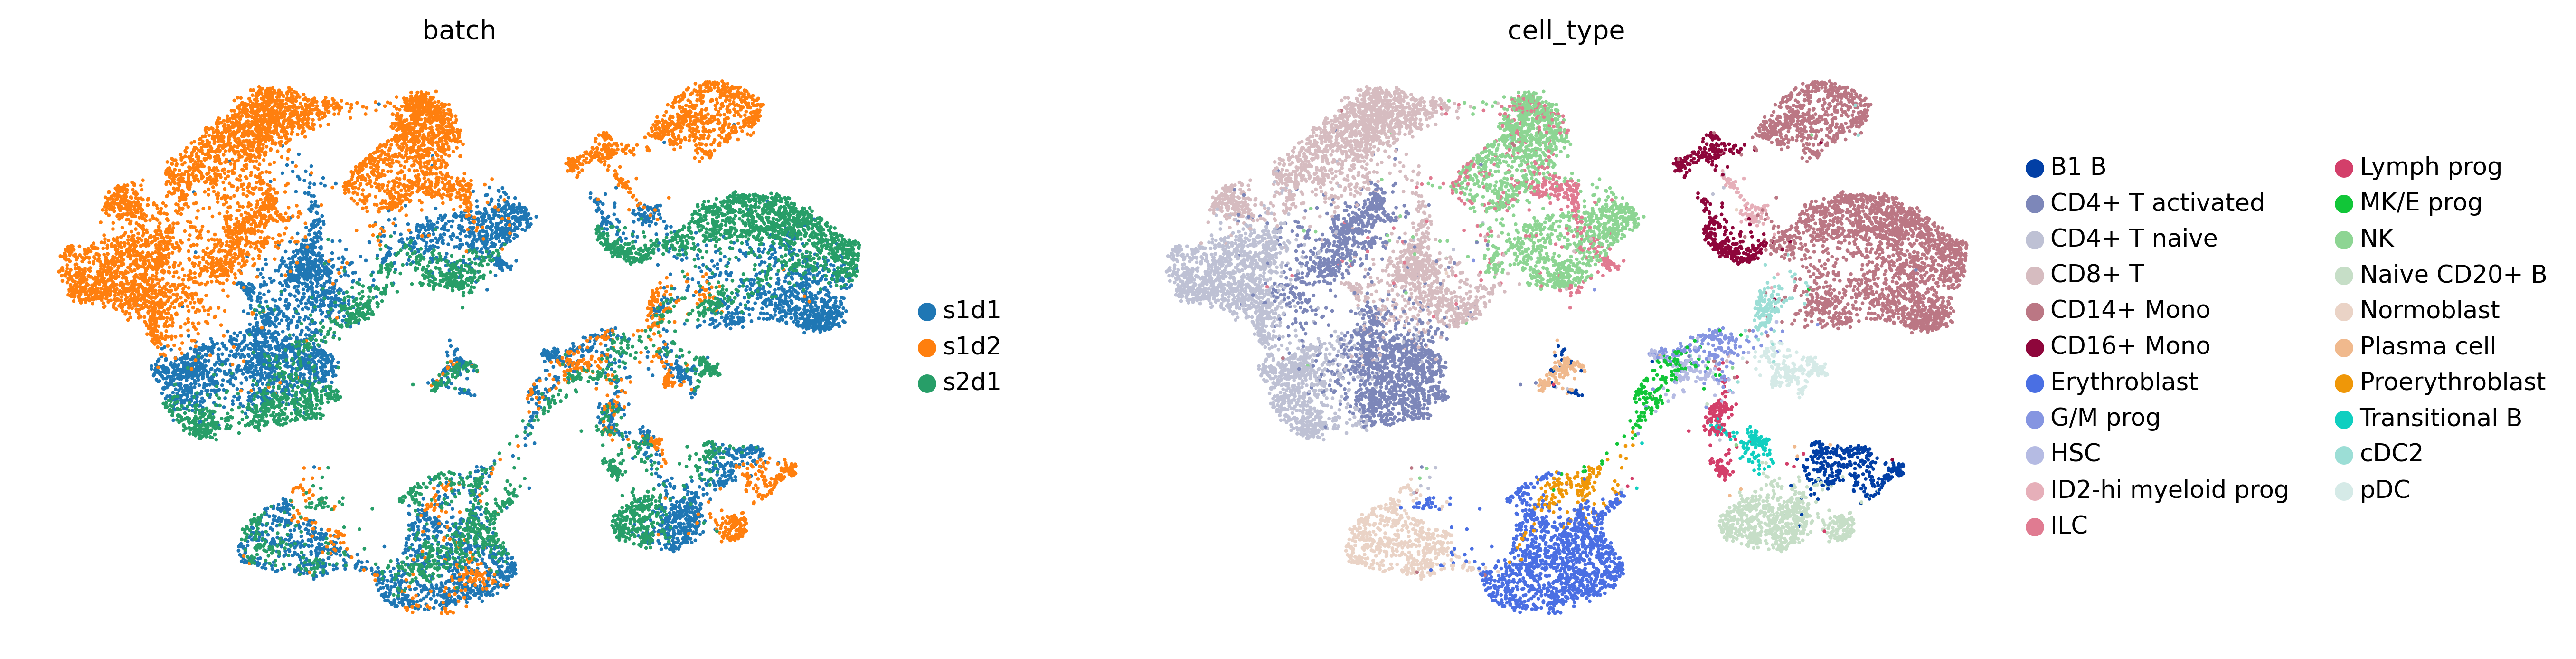

In [17]:
adata_train.obsm['X_NFinVAE'] = latent

sc.pp.neighbors(adata_train, use_rep='X_NFinVAE')
sc.tl.umap(adata_train)

sc.pl.umap(adata_train, color=['batch', 'cell_type'])

Using saved adata for latent representation!


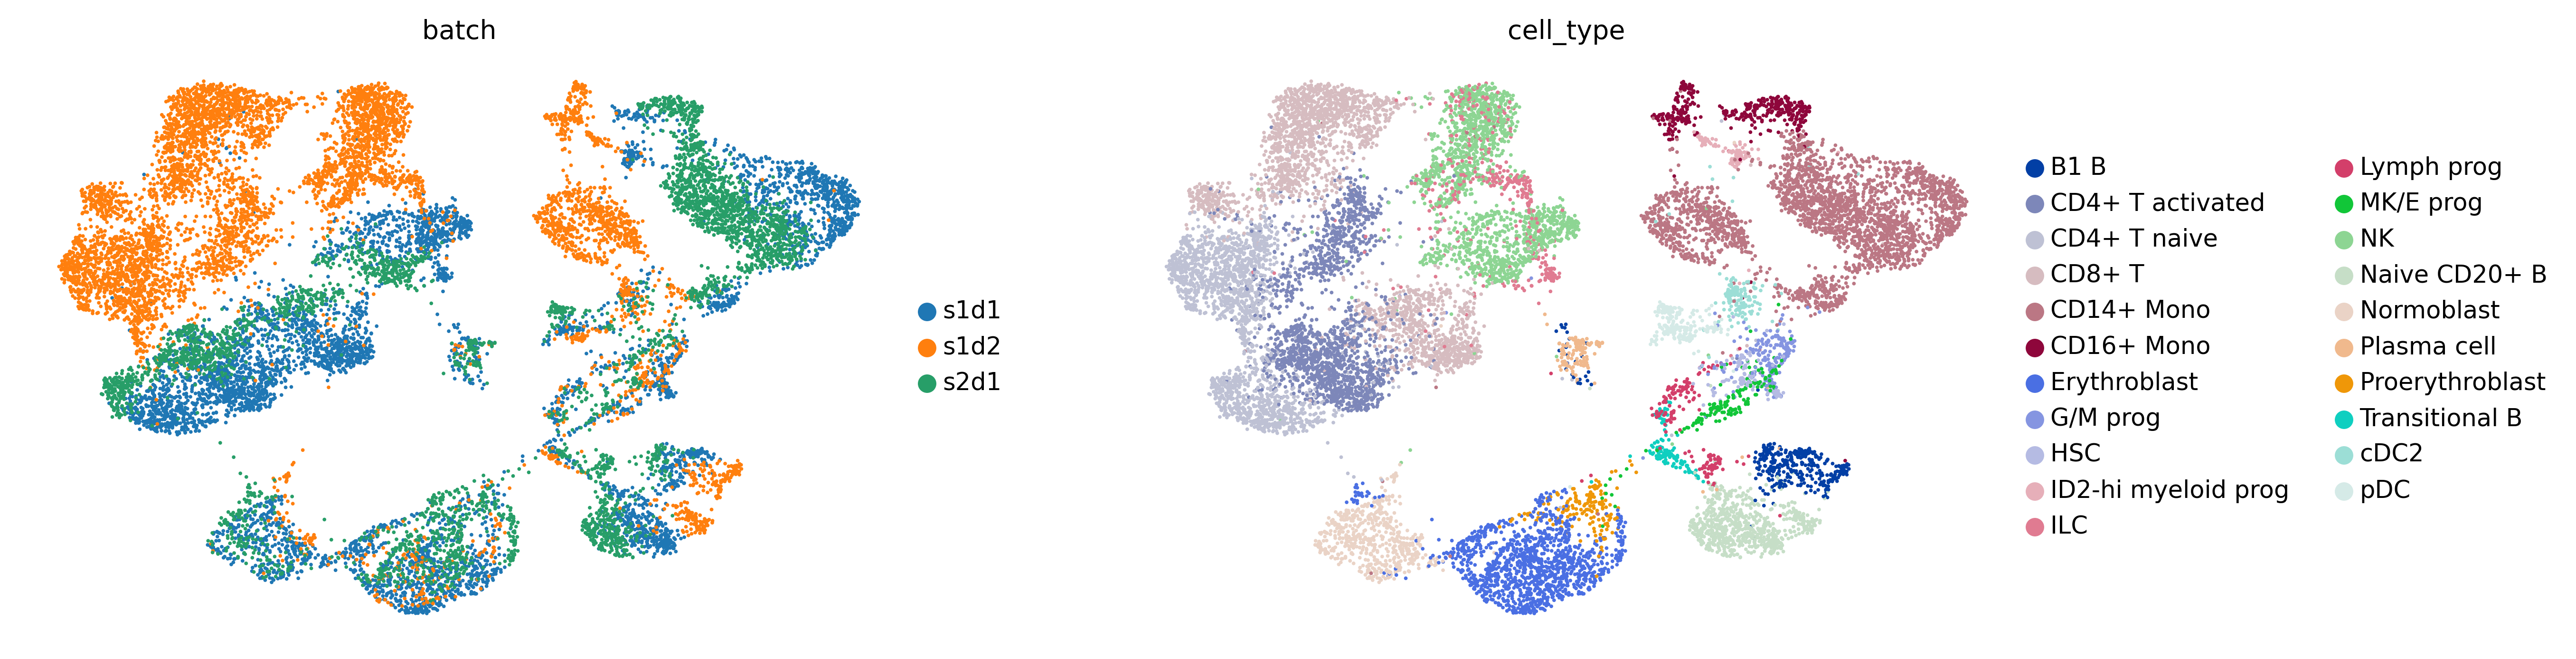

In [18]:
# Spurious latent representaion: here 1-dimensional -> plot full latent space (invariant + spurious representation)
full_latent = model.get_latent_representation(type='full')

adata_train.obsm['X_NFinVAE_full'] = full_latent

sc.pp.neighbors(adata_train, use_rep='X_NFinVAE_full')
sc.tl.umap(adata_train)

sc.pl.umap(adata_train, color=['batch', 'cell_type'])

# Saving and loading the model

In [19]:
# Save Hyperparameters in a dictionary

hp_dict = dict(
    layer = 'counts',
    batch_key = 'batch',
    label_key = 'cell_type',
    inv_covar_keys = inv_covar_keys,
    spur_covar_keys = spur_covar_keys,
    latent_dim = 10, 
    latent_dim_spur = 1,
    n_layers = 2, 
    hidden_dim = 154,
    activation = 'relu', 
    slope = 0.1, # only needed when activation is Leaky ReLU ('lrelu')
    device = 'cpu',
    normalize_constant = 1.0, 
    fix_mean_spur_prior = True,
    fix_var_spur_prior = False,
    decoder_dist = 'nb',
    batch_norm = True,
    batch_size = 256,
    reg_sm = 0.0,
    output_dim_prior_nn = 49,
    hidden_dim_prior = 56,
    n_layers_prior = 3,
)

# adata: can be saved separate if necessary

In [16]:
os.getcwd()

'/home/ferdi/nonlinear_irm/code'

In [20]:
# Save the pytroch module after training
model.save(save_dir='../checkpoints/test_general_invae/nfinvae_latent_10_checkpoint.pt')

Saving the pytorch module...
To load the model later you need to save the hyperparameters in a separate file/dictionary.


In [21]:
# Load the model
# one needs: adata, hyperparameters (in a dict) and the pytorch save directory
model = NFinVAE(adata_train, **hp_dict)

model.load('../checkpoints/test_general_invae/nfinvae_latent_10_checkpoint.pt')

Data loading done!
Loading the model from given checkpoint...


In [22]:
latent_loaded = model.get_latent_representation()

Using saved adata for latent representation!


In [23]:
# Check if the latent representation is the same before and after loaded:
np.array_equal(latent, latent_loaded)

True